In [25]:
# Estrategia de Implementación Incremental con ε-Greedy en Taxi-v3
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
import pygetwindow as gw

# Crear entorno
env = gym.make("Taxi-v3")

## Estados
Posición del taxi (fila y columna → 5x5 = 25 posiciones). 25

Ubicación del pasajero (Cuadrícula Roja, Cuadrícula Verde, Cuadrícula Amarilla, Cuadrícula Azul o "Dentro del taxi"). 5

Destino del pasajero (una de las cuatro cuadrículas). 4
La combinación de estos 3 nos da una cantidad de 500 estados posibles 25 x 5 x 4 = 500


## Movimientos
El taxi puede ejecutar 6 acciones:

- Moverse al sur

- Moverse al norte

- Moverse al este

- Moverse al oeste

- Recoger pasajero

- Dejar pasajero

## Recompensas
- Cada paso penaliza con -1, para motivar soluciones rápidas.

- Intentar recoger/dejar pasajero en el lugar incorrecto: penalización de -10.

- Entregar correctamente al pasajero: +20 de recompensa.

- El juego acaba cuando el taxi deja al pasajero en el lugar correcto. 

## Entrenamiento del agente

- Algoritmos de Gradientes

In [ ]:
# Parámetros
n_episodios = 10000
max_steps = 200
alpha = 0.1 # Tasa de aprendizaje

epsilons = [0.0, 0.01, 0.1]
recompensas_medias = np.zeros((len(epsilons), n_episodios))
Qs = []  # Para almacenar cada Q

num_states = env.observation_space.n
num_actions = env.action_space.n

NameError: name 'np' is not defined

En esta estrategia buscamos balancear dos cosas:

Exploración: probar acciones nuevas (quizás malas) para descubrir mejores opciones.

Explotación: usar lo que ya se conoce para obtener buenas recompensas.

Funciona así:

Con probabilidad ε, el agente elige una acción aleatoria (explora).

Con probabilidad 1 - ε, el agente elige la mejor acción conocida hasta ahora (explota).

Epsilon: 0.1: 100%|██████████| 10000/10000 [00:02<00:00, 3413.50it/s]


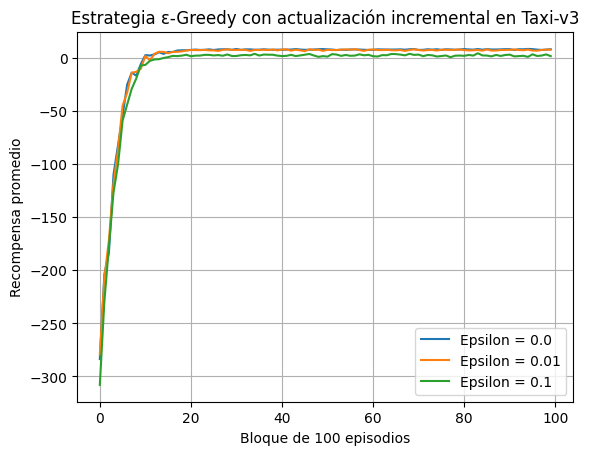

In [ ]:
# Entrenamiento para diferentes valores de epsilon
for i, epsilon in enumerate(epsilons):
    Q = np.zeros((num_states, num_actions))
    rewards = []

    for episodio in tqdm(range(n_episodios), desc=f"Epsilon: {epsilon}"):
        state, _ = env.reset()
        total_reward = 0

        for _ in range(max_steps):
            # Política ε-greedy
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.choice(num_actions)
            else:
                action = np.argmax(Q[state])

            # Tomar acción
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Actualización incremental
            best_next = np.max(Q[next_state])
            Q[state][action] += alpha * (reward + best_next - Q[state][action])

            state = next_state
            total_reward += reward

            if done:
                break

        rewards.append(total_reward)
        recompensas_medias[i][episodio] = total_reward

    Qs.append(Q)  # Guardar Q-table final de este epsilon

    # Mostrar rendimiento de cada epsilon
    def suavizar(lista, bloque=100):
        return [np.mean(lista[i:i + bloque]) for i in range(0, len(lista), bloque)]

    plt.plot(suavizar(recompensas_medias[i]), label=f"Epsilon = {epsilon}")

plt.xlabel("Bloque de 100 episodios")
plt.ylabel("Recompensa promedio")
plt.title("Estrategia ε-Greedy con actualización incremental en Taxi-v3")
plt.grid(True)
plt.legend()
plt.show()

    

In [ ]:
# Evaluar el mejor epsilon
promedios_finales = [np.mean(r) for r in recompensas_medias]
mejor_indice = np.argmax(promedios_finales)
mejor_epsilon = epsilons[mejor_indice]
mejor_Q = Qs[mejor_indice]
mejor_recompensa = recompensas_medias[mejor_indice]
np.save("rewards_incremental.npy", mejor_recompensa)

print(f"Mejor epsilon: {mejor_epsilon}")
print(f"Recompensa promedio: {promedios_finales[mejor_indice]:.2f}")

Mejor epsilon: 0.0
Recompensa promedio: -2.91


In [ ]:
# Mostrar Q-table final del mejor experimento
df_q = pd.DataFrame(mejor_Q)
df_q.columns = ["South", "North", "East", "West", "Pickup", "Dropoff"]
df_q.index.name = "State"
print("Q-table del mejor epsilon:")
print(df_q.head(10))

Q-table del mejor epsilon:
           South  North      East  West  Pickup  Dropoff
State                                                   
0       0.000000    0.0  0.000000   0.0     0.0      0.0
1      -3.615780   -3.7 -3.614938  -3.7    11.0     -4.0
2      -2.018857   -2.0 -2.011047  -2.0    15.0     -2.0
3      -3.089333   -3.1 -3.106946  -3.1    12.0     -4.0
4      -7.368278   -7.4  0.972173  -7.4    -8.0     -8.0
5       0.000000    0.0  0.000000   0.0     0.0      0.0
6      -0.533783   -7.4 -7.346642  -7.4    -8.0     -8.0
7       4.887736   -5.9 -5.957100  -5.9    -6.0     -6.0
8      10.144577   -4.2 -4.229686  -4.2    -5.0     -5.0
9       5.002929   -6.5 -6.504926  -6.5    -7.0     -7.0


Podemos obeservar que nuestro mejor resultado es con un epsilon de 0
 

In [ ]:
# Evaluar visualmente el comportamiento del agente con el mejor epsilon
env.close()
test_env = gym.make("Taxi-v3", render_mode="human")
state, _ = test_env.reset()
done = False
total_reward = 0

try:
    time.sleep(1)
    for w in gw.getWindowsWithTitle("Taxi"):
        w.activate()
        break
except Exception as e:
    print("No se pudo enfocar la ventana:", e)

while not done:
    action = np.argmax(mejor_Q[state])
    state, reward, terminated, truncated, _ = test_env.step(action)
    total_reward += reward
    done = terminated or truncated

test_env.close()
print("Recompensa total en prueba visual (mejor epsilon):", total_reward)

Recompensa total en prueba visual (mejor epsilon): 11
